## Lupus CD4+ T cells signature

Using De results from sorted CD4+ T cells from [Nakano et al. 2022](https://www.cell.com/cell/fulltext/S0092-8674(22)00924-2?_returnURL=https%3A%2F%2Flinkinghub.elsevier.com%2Fretrieve%2Fpii%2FS0092867422009242%3Fshowall%3Dtrue#mmc1)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import glob

import pertpy

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../3_DE_analysis/')
from DE_analysis_utils import *

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/

In [3]:
DATADIR="/mnt/oak/users/emma/data/GWT/"
os.makedirs('/mnt/oak/users/emma/data/GWT/cytotoxic_CD4_data/', exist_ok=True)

## Read Lupus DE genes 

In [4]:
# Table with fixed excel errors 
lupus_signature_df = pd.read_csv('../../metadata/SLE_DEGs_Nakano2022.csv.gz')

In [5]:
lupus_signature_df['Cell type'].unique()

array(['Naive CD4', 'Mem CD4', 'Th1', 'Th2', 'Th17', 'Tfh', 'Fr. I nTreg',
       'Fr. II eTreg', 'Fr. III T', 'Naive CD8', 'CM CD8', 'EM CD8',
       'TEMRA CD8', 'NK', 'Naive B', 'USM B', 'SM B', 'DN B',
       'Plasmablast', 'CL Mono', 'CD16p Mono', 'Int Mono', 'NC Mono',
       'mDC', 'pDC', 'Neu', 'LDG'], dtype=object)

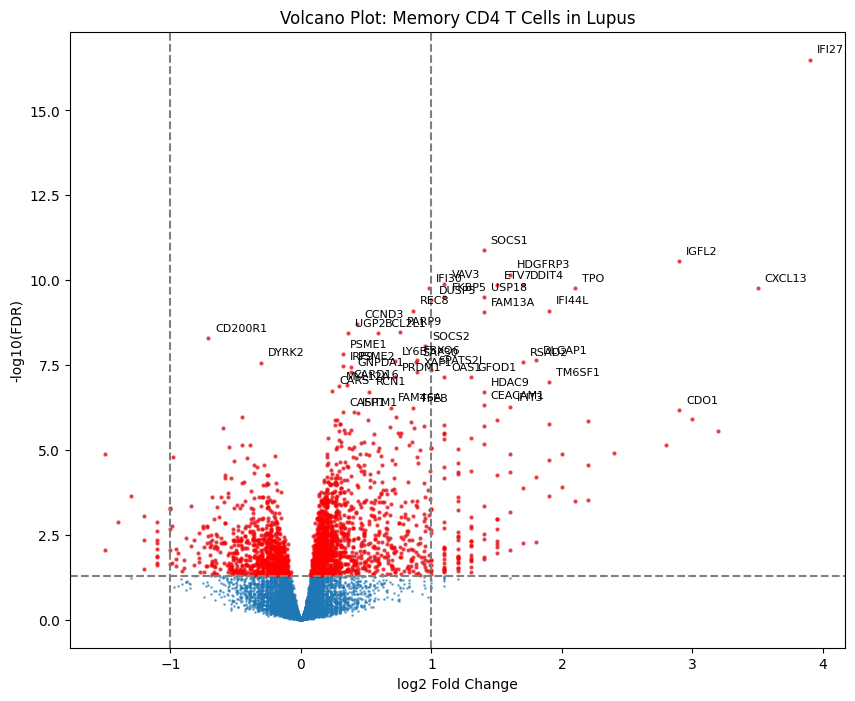

In [6]:
cd4_lupus_signature = lupus_signature_df[lupus_signature_df['Cell type'] == 'Mem CD4'].copy()

plt.figure(figsize=(10, 8))
plt.scatter(cd4_lupus_signature['logFC'], 
           -np.log10(cd4_lupus_signature['FDR']),
           s=1,
           alpha=0.5)

sig_genes = cd4_lupus_signature[cd4_lupus_signature['FDR'] < 0.05]
plt.scatter(sig_genes['logFC'],
           -np.log10(sig_genes['FDR']), 
           color='red',
           s=5,
           alpha=0.5)

# Add labels for top 20 genes by FDR
top_20_genes = sig_genes.nsmallest(50, 'FDR')
for _, gene in top_20_genes.iterrows():
    plt.annotate(gene['Gene'],
                xy=(gene['logFC'], -np.log10(gene['FDR'])),
                xytext=(5, 5),
                textcoords='offset points',
                fontsize=8)


plt.xlabel('log2 Fold Change')
plt.ylabel('-log10(FDR)')
plt.title('Volcano Plot: Memory CD4 T Cells in Lupus')

# Add horizontal line for p-value cutoff of 0.05
plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--')

# Add vertical lines for log2FC cutoffs of -1 and 1
plt.axvline(x=-1, color='gray', linestyle='--')
plt.axvline(x=1, color='gray', linestyle='--')

plt.show()

## Load perturb-seq signatures

In [7]:
# Import utility functions from DE_analysis_utils.py
import sys
import os
sys.path.append(os.path.abspath('../3_DE_analysis'))
from DE_analysis_utils import get_DE_results_long


In [8]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4iR1_Psomagen/'
experiment_name = 'CD4iR1_Psomagen'
adata_de = sc.read_h5ad(datadir + f'/DE_results_all_confounders/{experiment_name}.merged_DE_results.h5ad')

adata_de.layers['zscore'] = adata_de.layers['log_fc'] / adata_de.layers['lfcSE']
adata_de.layers['zscore'][np.where(adata_de.layers['zscore'] > 50)] = 50
for cond in adata_de.obs.culture_condition.unique():
    affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['adj_p_value'] < 0.1, axis=0)
    adata_de.var[f'n_signif_effects_{cond}'] = affected_gs_cond
    # affected_gs_cond = np.sum(adata_de[adata_de.obs['culture_condition'] == cond].layers['MASH_lfsr'] < 0.05, axis=0)
    # adata_de.var[f'n_mash_signif_effects_{cond}'] = affected_gs_cond

adata_de.var_names = adata_de.var['gene_name'].values
adata_de.var_names

Index(['TSPAN6', 'DPM1', 'C1orf112', 'FGR', 'CFH', 'FUCA2', 'GCLC', 'NFYA',
       'STPG1', 'NIPAL3',
       ...
       'SMIM33', 'MSANTD7', 'SCO2', 'C2orf81', 'TBCE', 'ARHGAP11B', 'F8A1',
       'HOMEZ', 'ENSG00000290797', 'SOD2'],
      dtype='object', length=10079)

In [9]:
# Load summary stats
DE_stats = pd.read_csv(datadir + f'/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)
keep_targets = DE_stats[ (DE_stats.n_total_de_genes > 1)].target_name.tolist()
print(len(keep_targets))

7402


## Fit regression model

In [10]:
from perturb2tissue_eval import *


def unpack_state_results(model_results, state):
    return {
        'p2t_model': model_results[state]['p2t_model'],
        'p2t_model_k562': model_results[state]['p2t_model_k562'],
        'X_perturbs': model_results[state]['X_perturbs'],
        'y_target': model_results[state]['y_target'],
        'common_gs': model_results[state]['common_gs']
    }

In [11]:
target_state = 'Mem CD4'
perturb_layer = 'log_fc'
ctrl_de = None
n_pcs = 60
n_splits = 5
n_repeats = 1
cond = 'Rest'

# Get target state values
y_target = lupus_signature_df.pivot_table(index='Gene', columns='Cell type', values='logFC')[target_state].dropna()

# Find common genes between all DE results
common_gs = np.intersect1d(y_target.index, adata_de.var_names)

y_target = y_target.loc[common_gs]

# Get responses in stim cells
print(f"Getting perturbation responses for condition: {cond}")
X_perturbs = sc.get.obs_df(adata_de[adata_de.obs.culture_condition == cond], 
                            ['target_contrast_gene_name'] + list(common_gs), 
                            layer=perturb_layer)
X_perturbs = X_perturbs.set_index('target_contrast_gene_name').T
print(f"Perturbation matrix shape: {X_perturbs.shape}")

# Mask effects in cis
X_perturbs_masked = X_perturbs.copy()
mask = pd.DataFrame(False, index=X_perturbs_masked.index, columns=X_perturbs_masked.columns)
for idx in X_perturbs_masked.index:
    if idx in X_perturbs_masked.columns:
        mask.loc[idx, idx] = True
X_perturbs_masked = X_perturbs_masked.mask(mask)
# Impute masked values with column means
X_perturbs_masked = X_perturbs_masked.fillna(X_perturbs_masked.mean())

# Train model on CD4 cells
print(f"Training CD4 model with {n_pcs} PCs, {n_splits} splits, {n_repeats} repeats")
p2t_model = Perturb2TissueModel(pca_transform=True, n_pcs=n_pcs, n_splits=n_splits, n_repeats=n_repeats, positive=False)
p2t_model.fit(X_perturbs_masked, y_target, model_id=f'{cond}')

Getting perturbation responses for condition: Rest
Perturbation matrix shape: (8469, 8481)
Training CD4 model with 60 PCs, 5 splits, 1 repeats


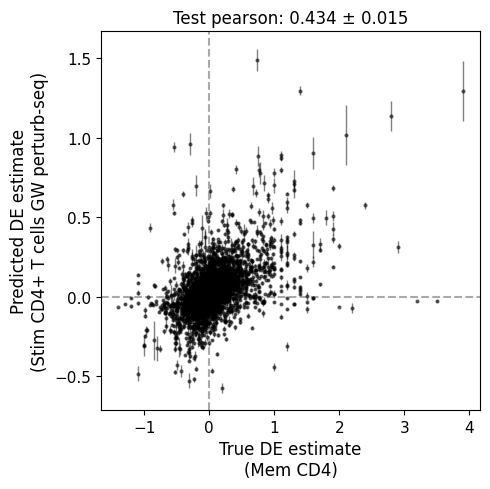

In [12]:
st = target_state
common_gs_ids_df = adata_de[:, common_gs].var[['gene_ids', 'gene_name']]
common_gs_ids = common_gs_ids_df.gene_ids

# Create a figure with subplots for all conditions
fig, axes = plt.subplots(1, 1, figsize=(5, 5))

# Process each state
# Plot predictions for the main model in the top subplot
p2t_model.plot_prediction(X_perturbs, y_target, plot_metric='pearson', ax=axes, return_ax=True)
axes.set_ylabel('Predicted DE estimate\n(Stim CD4+ T cells GW perturb-seq)', fontsize=12)
axes.set_xlabel(f'True DE estimate\n({st})', fontsize=12)
axes.axhline(y=0, color='darkgrey', linestyle='--')
axes.axvline(x=0, color='darkgrey', linestyle='--')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Mem CD4')

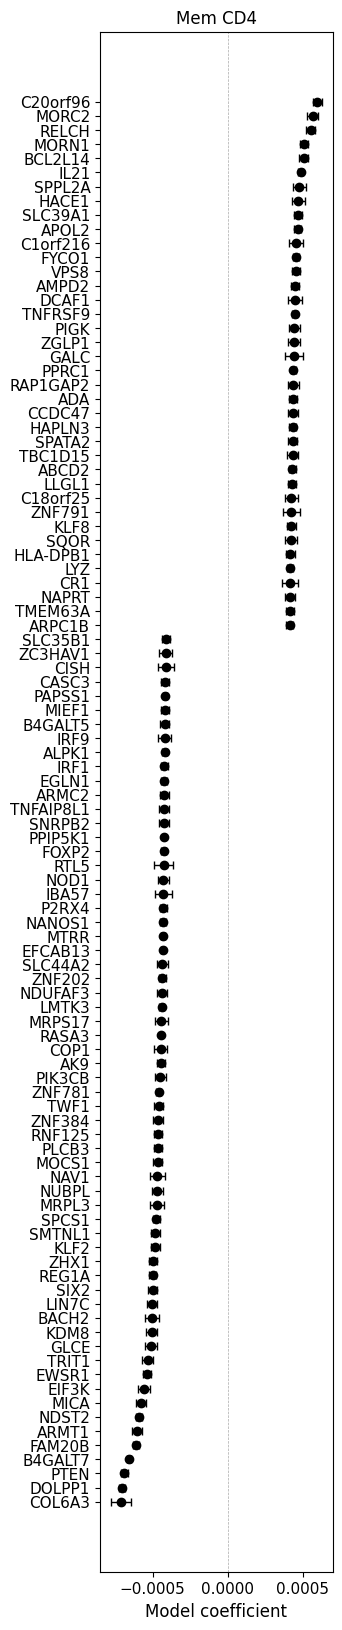

In [13]:
# Create a figure with subplots for all states in one row
fig, ax = plt.subplots(1, 1, figsize=(3, 20))
p2t_model.plot_coefs(top_n=100, ax=ax, return_ax=True, show_labels=True)
ax.set_title(st)

# Association with genes associated with SLE by genetics

Here I quickly downloaded a list of genes from OpenTargets platform, for a quick demo (https://platform.opentargets.org/disease/MONDO_0007915/associations). Validate the gene list with Mineto or with more precise filtering with OT platform (e.g. subsetting only to genetic evidence that we care about).

In [82]:
OT_genetics_genes_SLE = pd.read_table('../../metadata/OT-MONDO_0007915-associated-targets-6_17_2025-v25_03.tsv')
OT_genetics_genes_SLE = OT_genetics_genes_SLE[OT_genetics_genes_SLE['globalScore'] > 0.2] # an arbitrary cutoff 

In [77]:
r2_perturb = p2t_model.get_r2(X_perturbs, y_target)

In [83]:
model_coefs = p2t_model.get_coefs()
model_coefs = pd.concat([model_coefs, r2_perturb], axis=1)
model_coefs['is_OT_associated'] = np.where(model_coefs.index.isin(OT_genetics_genes_SLE['symbol']), 'yes', 'no')

In [84]:
model_coefs

,coef_mean,coef_sem,r2,is_OT_associated
PHF23,0.000164,0.000035,0.003389,no
GTSE1,-0.000351,0.000021,0.013461,no
SLC25A24,0.000064,0.000032,0.001042,no
C11orf21,0.000172,0.000028,0.000459,no
AMPD2,0.000448,0.000026,0.011714,no
...,...,...,...,...
FAM185A,0.000127,0.000017,0.001196,no
SMKR1,-0.000035,0.000028,0.000846,no
ZCCHC3,-0.000148,0.000025,0.002299,no
GTF2I,-0.000148,0.000036,0.002258,yes


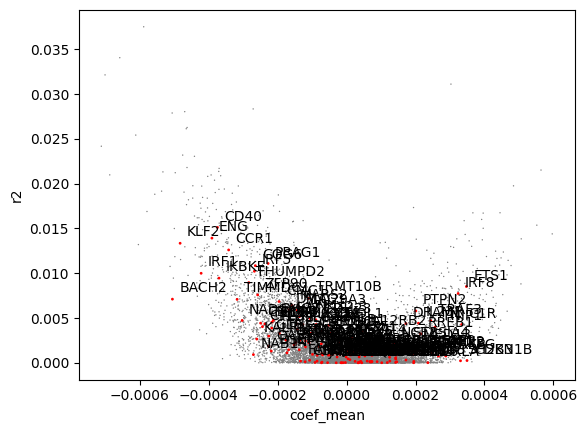

In [85]:
sns.scatterplot(data=model_coefs, x='coef_mean', y='r2', s=1, edgecolor='none', color='grey')
# Plot OT-associated genes as red points
ot_genes = model_coefs[model_coefs.is_OT_associated == 'yes']
sns.scatterplot(data=ot_genes, x='coef_mean', y='r2', s=4, edgecolor='none', color='red')
ot_genes
# Add text annotations for gene names
for idx, row in ot_genes.iterrows():
    plt.annotate(idx, (row['coef_mean'], row['r2']), 
                xytext=(5, 5), textcoords='offset points', 
                fontsize=10)

<Axes: xlabel='r2', ylabel='Proportion'>

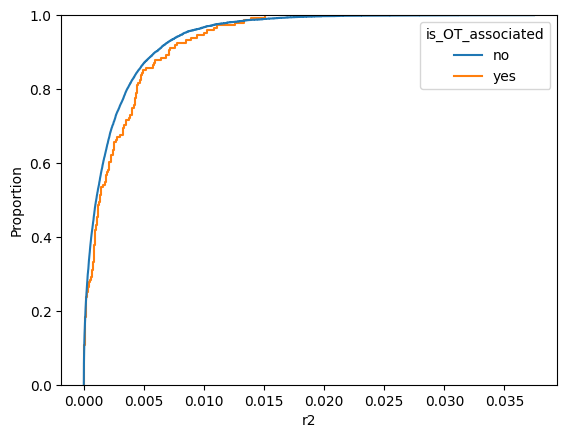

In [86]:
sns.ecdfplot(data=model_coefs, hue='is_OT_associated', x='r2')

## Questions 

Checking robustness
- Test robustness & variability across splits (increasing number of splits and repeats) - I noticed more variability in this case than other applications, perhaps because we are using raw log-fold changes instead of z-score that account for the noice

Comparisons across cell types
- Are the predictions significantly different between fit on perturbation responses in resting or stimulated cells? We expect the resting state to be more similar to the Memory CD4+ T cells observed in patients, but it would be useful to compare 
- How does the fit compare modelling responses in different types of CD4+ T cells (incl Naive/Tregs)? Here we also have sorted Th1/Th2, but not sure what the difference with CD4 Mem is, this should be checked in the original study and Mineto can give more insights. 
- Can we use fit on unrelated cell types (e.g. Monocytes) as negative controls? Compare fit on test set across cell types.
- Can we use comparison of DE genes across cell types to distinguish systemic from cell type specific response? Ideally, we would like to separate regulators of responses that are a _consequence_ of disease (e.g. IFN signalling) from root causes. The place to start would be to check how well a model trained on perturb-seq predicts the effect on different classes of genes. Note that the original study has DE results for both SLE vs healthy (what we are using here (I think??)) and active vs inactive SLE (see Suppl tables). Comparing fit in both might be useful. 

Enrichment of genetic signals (With a curated list of genes associated to SLE by genetics):
- Do we see a significant enrichment in disease-associated genes amongst the predicted putative regulators? Compare to negative control cell types
- Are GWAS genes more likely to be upstream (predicted regulators) or downstream (differentially expressed)? 